In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape",
    "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]
df = pd.read_csv(url, header=None, names=columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

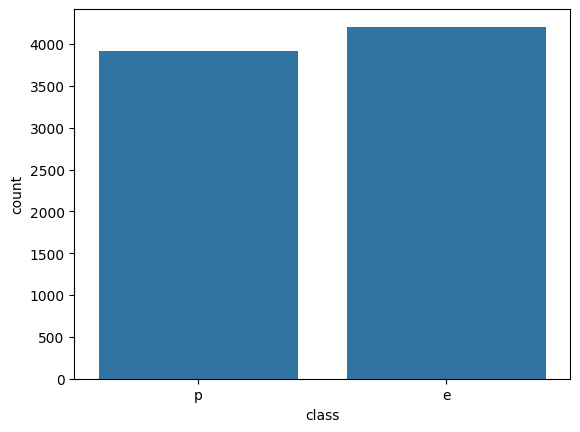

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df.replace('?', np.nan, inplace=True)

df.info()
print(df.isnull().sum())
print(df['class'].value_counts())

sns.countplot(x='class', data=df)
plt.show()


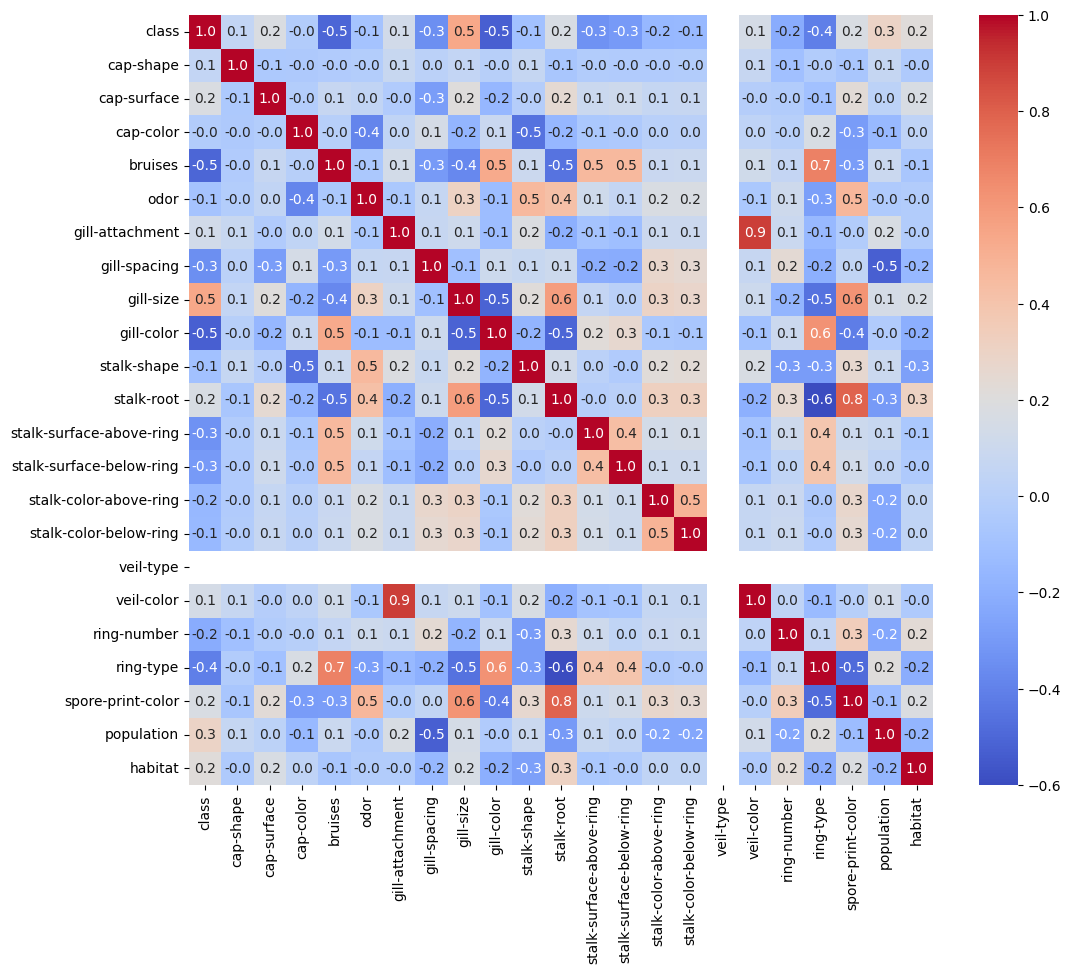

In [10]:
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.show()

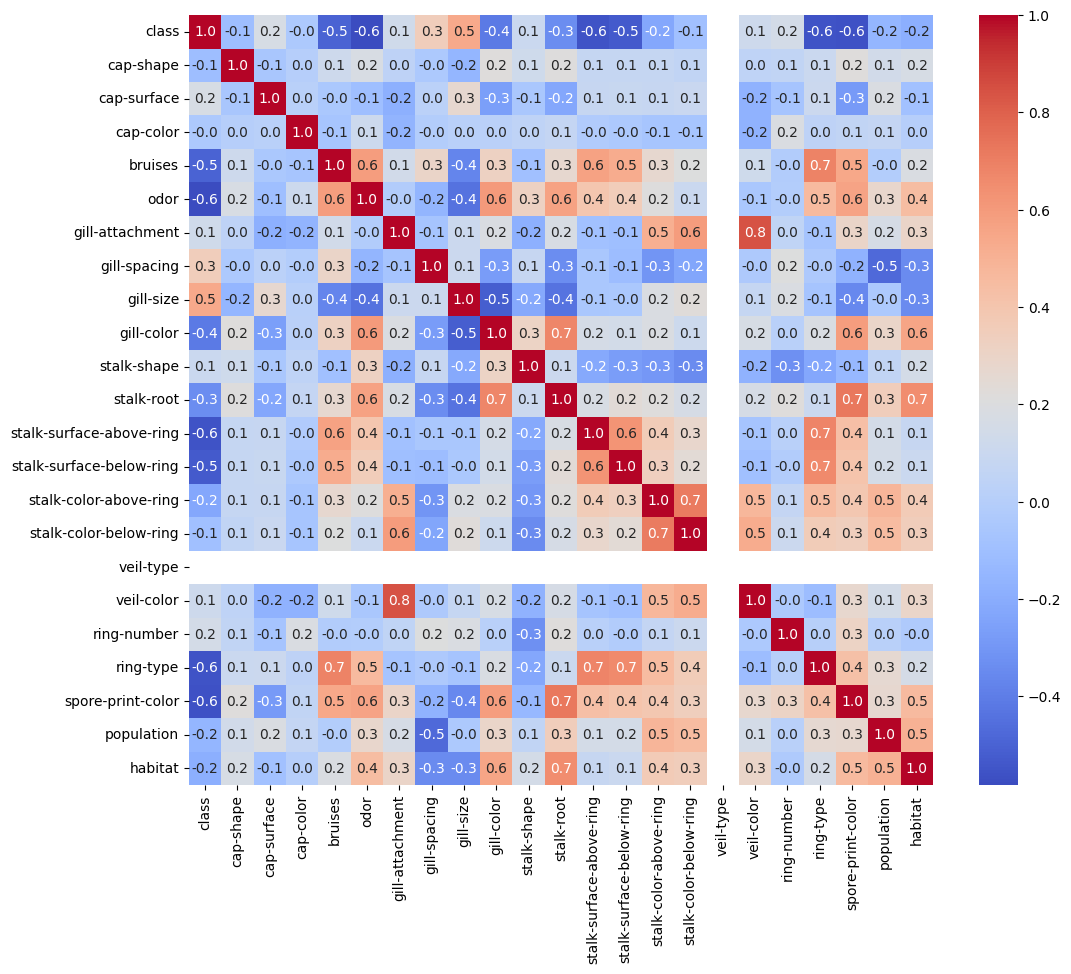

In [13]:
for col in df.columns:
    df[col] = pd.factorize(df[col])[0]

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.show()

X = df.drop('class', axis=1).values
y = df['class'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value


class ManualDecisionTree:
    def __init__(self, min_samples_split=2, max_depth=10):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, depth=0):
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape

        if n_samples >= self.min_samples_split and depth < self.max_depth:
            best = self.get_best_split(dataset, n_features)
            if best["info_gain"] > 0:
                left = self.build_tree(best["left"], depth + 1)
                right = self.build_tree(best["right"], depth + 1)
                return Node(best["feature"], best["threshold"], left, right, best["info_gain"])

        return Node(value=self.leaf_value(y))

    def get_best_split(self, dataset, n_features):
        best = {"info_gain": -1}
        y = dataset[:, -1]

        for f in range(n_features):
            for t in np.unique(dataset[:, f]):
                left, right = self.split(dataset, f, t)
                if len(left) and len(right):
                    gain = self.information_gain(y, left[:, -1], right[:, -1])
                    if gain > best["info_gain"]:
                        best = {
                            "feature": f,
                            "threshold": t,
                            "left": left,
                            "right": right,
                            "info_gain": gain
                        }
        return best

    def split(self, dataset, f, t):
        left = dataset[dataset[:, f] <= t]
        right = dataset[dataset[:, f] > t]
        return left, right

    def entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs))

    def information_gain(self, parent, left, right):
        wl, wr = len(left)/len(parent), len(right)/len(parent)
        return self.entropy(parent) - (wl*self.entropy(left) + wr*self.entropy(right))

    def leaf_value(self, y):
        return np.bincount(y.astype(int)).argmax()

    def fit(self, X, y):
        self.root = self.build_tree(np.c_[X, y])

    def predict(self, X):
        return np.array([self._predict(x, self.root) for x in X])

    def _predict(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict(x, node.left)
        return self._predict(x, node.right)


In [16]:
from sklearn.metrics import accuracy_score

dt_manual = ManualDecisionTree(max_depth=5)
dt_manual.fit(X_train.values, y_train.values)

y_pred_manual = dt_manual.predict(X_test.values)

dt_accuracy = accuracy_score(y_test.values, y_pred_manual)
print("Manual Decision Tree Accuracy:", dt_accuracy)


Manual Decision Tree Accuracy: 0.9991796554552912


n_estimators=1, Accuracy=0.9988
n_estimators=50, Accuracy=1.0000
n_estimators=100, Accuracy=1.0000
n_estimators=150, Accuracy=1.0000
n_estimators=200, Accuracy=1.0000
n_estimators=250, Accuracy=1.0000


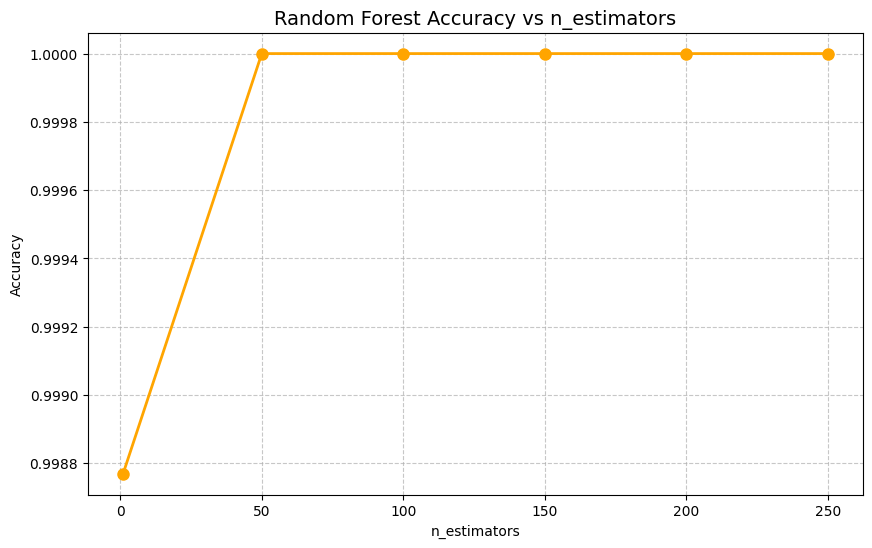

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

rf_accuracies = []
n_estimators_list = [1, 50, 100, 150, 200, 250]

for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    rf_accuracies.append(acc)
    print(f"n_estimators={n}, Accuracy={acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, rf_accuracies, marker='o', color='orange', linewidth=2, markersize=8)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs n_estimators", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [18]:
best_rf_acc = max(rf_accuracies)

print(f"Manual Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Best Random Forest Accuracy: {best_rf_acc:.4f}")

if best_rf_acc > dt_accuracy:
    print("Random Forest performed better")
elif dt_accuracy > best_rf_acc:
    print("Decision Tree performed better")
else:
    print("Both models performed equally")


Manual Decision Tree Accuracy: 0.9992
Best Random Forest Accuracy: 1.0000
Random Forest performed better


Manual Decision Tree Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Random Forest Report (n=250):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



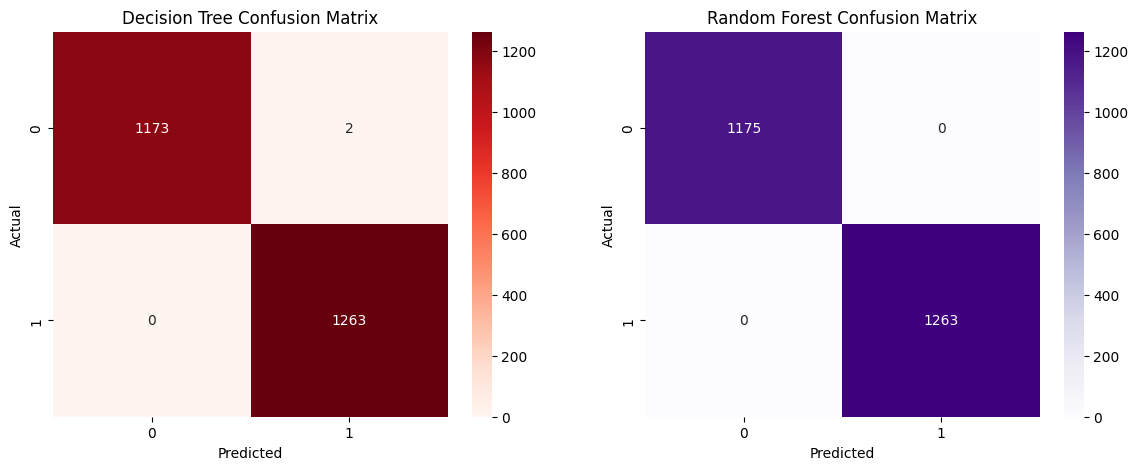

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Manual Decision Tree Report:")
print(classification_report(y_test, y_pred_manual))

y_pred_rf = rf.predict(X_test)
print("Random Forest Report (n=250):")
print(classification_report(y_test, y_pred_rf))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_manual), annot=True, fmt='d', cmap='Reds', ax=axes[0])
axes[0].set_title('Decision Tree Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Purples', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()
